<div style="padding:4px; line-height:20px; width:80%">
    <div style="text-align:center; font-size:18px; font-weight:bold">Pneumonia Detection</div>
    <h3>Content:</h3>
    <p>
Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of  the  lungs.  In  this  challenge,  you’re  required  to  build  an  algorithm  to  detect  a  visual  signal  for  pneumonia  in  medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs
    </p>
     <h3>DATA DESCRIPTION:</h3>
    <p>
In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data
    </p>
 </div>

In [1]:
import os
import PIL
import csv
import numpy as np
import pandas as pd 
import seaborn as sns
import pydicom as dicom
import random
import cv2
import math
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import SeparableConv2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from tqdm import tqdm
%matplotlib inline

In [2]:
sns.set_theme(style="whitegrid")

# make it True if you want in PNG format
PNG = False
# Specify the .dcm folder path
folder_test_path = r"data\stage_2_test_images"

# Specify the .dcm train path
folder_train_path = r"data\stage_2_train_images\stage_2_train_images"

# Specify the .jpg/.png Test data path
jpg_test_path = r"data\JPG_test"

# Specify Traing jpg path
jpg_train_path= r"data\JPG_train"

#create train and test data folder
if not os.path.exists(jpg_test_path):
    os.makedirs(jpg_test_path)
    
if not os.path.exists(jpg_train_path):
    os.makedirs(jpg_train_path)

#Reading Image Path
test_images_list = os.listdir(folder_test_path)

#Reading training impage path
train_images_list = os.listdir(folder_train_path)

#reading Image sample file
dicom_image_description = pd.read_csv(r"data\stage_2_sample_submission.csv")

#reding lavel from data
dicom_image_lavel = pd.read_csv(r"data\stage_2_detailed_class_info.csv")

#reding Traning lavel from data
dicom_train_label = pd.read_csv(r"data\stage_2_train_labels.csv")

print(os.getcwd())

E:\aiml\cap-project


In [3]:
dicom_image_description

patientId PredictionString
0     0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1     0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2     000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3     000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4     00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100
...                                    ...              ...
2995  c1e88810-9e4e-4f39-9306-8d314bfc1ff1  0.5 0 0 100 100
2996  c1ec035b-377b-416c-a281-f868b7c9b6c3  0.5 0 0 100 100
2997  c1ef5b66-0fd7-49d1-ae6b-5af84929414b  0.5 0 0 100 100
2998  c1ef6724-f95f-40f1-b25b-de806d9bc39d  0.5 0 0 100 100
2999  c1f55e7e-4065-4dc0-993e-a7c1704c6036  0.5 0 0 100 100

[3000 rows x 2 columns]

In [4]:
dicom_image_lavel

patientId                         class
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2      00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4      00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
...                                     ...                           ...
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8                  Lung Opacity
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba                        Normal
30224  c1f6b555-2eb1-4231-98f6-50a963976431                        Normal
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity

[30227 rows x 2 columns]

In [5]:
dicom_image_lavel.pivot_table(index="class", aggfunc=len).sort_values('patientId', ascending=False)

patientId
class                                  
No Lung Opacity / Not Normal      11821
Lung Opacity                       9555
Normal                             8851

In [6]:
print(f"Total Number of Train Images",len(train_images_list))
print(f"Total Number of Test Images",len(test_images_list))

Total Number of Train Images 26684
Total Number of Test Images 3000


In [7]:
dicom_train_label

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
...                                     ...    ...    ...    ...     ...   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  
0           0  
1           0  
2           0  
3           0  
4           1  
...       ...  
30222       1  
30223       0  
30224       0  
30225       1  
30226       1  

[30227 rows x 6 columns]

In [8]:
merged_df = pd.merge(dicom_train_label, dicom_image_lavel, on='patientId')

In [9]:
merged_df

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
...                                     ...    ...    ...    ...     ...   
37624  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
37625  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
37626  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
37627  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   
37628  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target                         class  
0           0  No Lung Opacity / Not Normal  
1           0  No Lung Opacity / Not Normal  
2           0  No Lung Opacity / Not Normal  
3           0                        Normal  
4           1                  Lung Opacity  
...       ...                           ...  
37624       0                        Normal  
37625       1                  Lung Opacity  
37626       1                  Lung Opacity  
37627       1                  Lung Opacity  
37628       1                  Lung Opacity  

[37629 rows x 7 columns]

In [10]:
#lung Opacity only data
long_opacity = merged_df[merged_df['Target'] == 1]

In [11]:
#Normal Lungs 
lung_normal = merged_df[merged_df['Target'] == 0]

In [12]:
long_opacity.head()

patientId      x      y  width  height  Target  \
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
6   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
7   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
10  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1   

           class  
4   Lung Opacity  
5   Lung Opacity  
6   Lung Opacity  
7   Lung Opacity  
10  Lung Opacity

In [13]:
lung_normal.head()

patientId   x   y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb NaN NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5 NaN NaN    NaN     NaN       0   
8  00569f44-917d-4c86-a842-81832af98c30 NaN NaN    NaN     NaN       0   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
8  No Lung Opacity / Not Normal

In [14]:
#converting .dcm row file to .jpg Files
PNG = False
def covert_dcm_to_jpg(source_image_path, target_image_path):
    images_path = os.listdir(source_image_path)
    target_image_list=''
    if not os.listdir(target_image_path):
        for n , image in enumerate(images_path):
            ds = dicom.dcmread(os.path.join(source_image_path, image))
            pixel_array_numpy = ds.pixel_array
            if PNG == False:
                image = image.replace('.dcm', '.jpg')
            else:
                image = image.replace('.dcm', '.png')    
            cv2.imwrite(os.path.join(target_image_path, image), pixel_array_numpy)    
            if n % 250 == 0:
                print('{} Image has Converted'.format(n))        
        target_image_list = os.listdir(target_image_path)
    else:
        target_image_list = os.listdir(target_image_path)
    return target_image_list

In [15]:
#DCM to JPEG test Image Converting
test_image_list = covert_dcm_to_jpg(folder_test_path, jpg_test_path)

In [16]:
np.array(test_image_list)

array(['0000a175-0e68-4ca4-b1af-167204a7e0bc.jpg',
       '0005d3cc-3c3f-40b9-93c3-46231c3eb813.jpg',
       '000686d7-f4fc-448d-97a0-44fa9c5d3aa6.jpg', ...,
       'c1ef5b66-0fd7-49d1-ae6b-5af84929414b.jpg',
       'c1ef6724-f95f-40f1-b25b-de806d9bc39d.jpg',
       'c1f55e7e-4065-4dc0-993e-a7c1704c6036.jpg'], dtype='<U40')

In [17]:
#DCM to JPEG Traingin Image Converting
train_image_list = covert_dcm_to_jpg(folder_train_path, jpg_train_path)

In [18]:
np.array(train_image_list)

array(['0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg',
       '000924cf-0f8d-42bd-9158-1af53881a557.jpg',
       '000db696-cf54-4385-b10b-6b16fbb3f985.jpg', ...,
       'fffc95b5-605b-4226-80ab-62caec682b22.jpg',
       'fffcff11-d018-4414-971a-a7cefa327795.jpg',
       'fffec09e-8a4a-48b1-b33e-ab4890ccd136.jpg'], dtype='<U40')

In [20]:
cdf = dicom_image_lavel.copy(deep=True)

In [21]:
cdf["image"]= cdf["patientId"]+".jpg"

In [22]:
cdf=cdf.loc[:, cdf.columns != 'patientId']
cdf

class                                     image
0      No Lung Opacity / Not Normal  0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg
1      No Lung Opacity / Not Normal  00313ee0-9eaa-42f4-b0ab-c148ed3241cd.jpg
2      No Lung Opacity / Not Normal  00322d4d-1c29-4943-afc9-b6754be640eb.jpg
3                            Normal  003d8fa0-6bf1-40ed-b54c-ac657f8495c5.jpg
4                      Lung Opacity  00436515-870c-4b36-a041-de91049b9ab4.jpg
...                             ...                                       ...
30222                  Lung Opacity  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.jpg
30223                        Normal  c1edf42b-5958-47ff-a1e7-4f23d99583ba.jpg
30224                        Normal  c1f6b555-2eb1-4231-98f6-50a963976431.jpg
30225                  Lung Opacity  c1f7889a-9ea9-4acb-b64c-b737c929599a.jpg
30226                  Lung Opacity  c1f7889a-9ea9-4acb-b64c-b737c929599a.jpg

[30227 rows x 2 columns]

In [23]:
train_df = pd.DataFrame(data=np.array(train_image_list), columns=['image'])
test_df = pd.DataFrame(data=np.array(test_image_list), columns=['image'])

In [24]:
#Mapping Class In train and test data set
test_df['class'] = cdf['class']
train_df['class'] = cdf['class']

In [25]:
test_df

image                         class
0     0000a175-0e68-4ca4-b1af-167204a7e0bc.jpg  No Lung Opacity / Not Normal
1     0005d3cc-3c3f-40b9-93c3-46231c3eb813.jpg  No Lung Opacity / Not Normal
2     000686d7-f4fc-448d-97a0-44fa9c5d3aa6.jpg  No Lung Opacity / Not Normal
3     000e3a7d-c0ca-4349-bb26-5af2d8993c3d.jpg                        Normal
4     00100a24-854d-423d-a092-edcf6179e061.jpg                  Lung Opacity
...                                        ...                           ...
2995  c1e88810-9e4e-4f39-9306-8d314bfc1ff1.jpg                  Lung Opacity
2996  c1ec035b-377b-416c-a281-f868b7c9b6c3.jpg  No Lung Opacity / Not Normal
2997  c1ef5b66-0fd7-49d1-ae6b-5af84929414b.jpg  No Lung Opacity / Not Normal
2998  c1ef6724-f95f-40f1-b25b-de806d9bc39d.jpg                  Lung Opacity
2999  c1f55e7e-4065-4dc0-993e-a7c1704c6036.jpg                  Lung Opacity

[3000 rows x 2 columns]

In [26]:
train_df

image                         class
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg  No Lung Opacity / Not Normal
1      000924cf-0f8d-42bd-9158-1af53881a557.jpg  No Lung Opacity / Not Normal
2      000db696-cf54-4385-b10b-6b16fbb3f985.jpg  No Lung Opacity / Not Normal
3      000fe35a-2649-43d4-b027-e67796d412e0.jpg                        Normal
4      001031d9-f904-4a23-b3e5-2c088acd19c6.jpg                  Lung Opacity
...                                         ...                           ...
26679  fffb2395-8edd-4954-8a89-ffe2fd329be3.jpg                        Normal
26680  fffba05a-1635-4545-9bbd-57ad4cfe8d27.jpg                        Normal
26681  fffc95b5-605b-4226-80ab-62caec682b22.jpg  No Lung Opacity / Not Normal
26682  fffcff11-d018-4414-971a-a7cefa327795.jpg  No Lung Opacity / Not Normal
26683  fffec09e-8a4a-48b1-b33e-ab4890ccd136.jpg  No Lung Opacity / Not Normal

[26684 rows x 2 columns]

In [27]:
# Data Analysis Class Label Plating bar chart

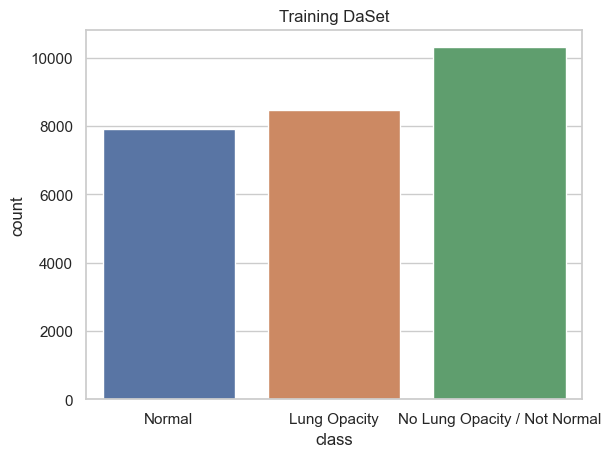

In [28]:
sns.countplot(data=train_df, x="class", order=train_df["class"].value_counts(ascending=True).astype("category").index).set(
    title="Training DaSet")
plt.show()

In [29]:
print(train_df['class'].value_counts().keys())
print(train_df['class'].value_counts().values)

Index(['No Lung Opacity / Not Normal', 'Lung Opacity', 'Normal'], dtype='object')
[10310  8471  7903]


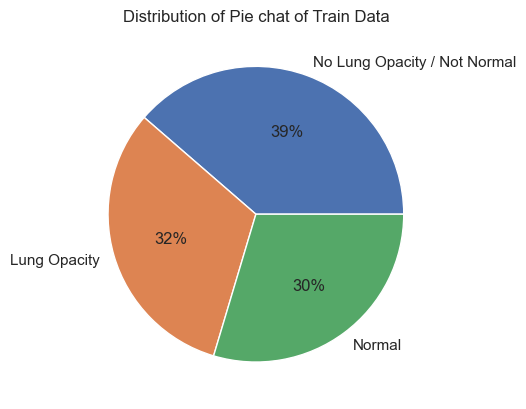

In [30]:
chatData = train_df['class'].value_counts().values
plt.pie(chatData, labels=train_df['class'].value_counts().keys(), autopct='%.0f%%')
plt.title('Distribution of Pie chat of Train Data')
plt.show()

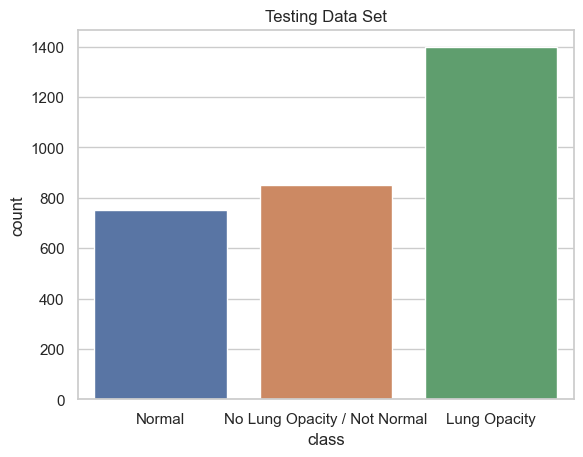

In [31]:
#test Data visulization
sns.countplot(data=test_df, x="class", order=test_df["class"].value_counts(ascending=True).astype("category").index).set(
    title="Testing Data Set")
plt.show()

<h2> Data Visualization and Procession </h2>

In [32]:
def visualize_data_class(data_path, data_df):
    plt.figure(figsize=(18, 18))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        img = plt.imread(os.path.join(data_path, data_df['image'][i]))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(data_df['class'][i], fontsize = 16)
    plt.tight_layout()
    
def histogram_Visualization(data_path, data_df):
    plt.figure(figsize=(18, 18))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        img = plt.imread(os.path.join(data_path, data_df['image'][i]))
        plt.hist(img.ravel(),bins=50, density=True)
        plt.axis('off')
        plt.title(data_df['class'][i], fontsize = 16)
    plt.tight_layout()    

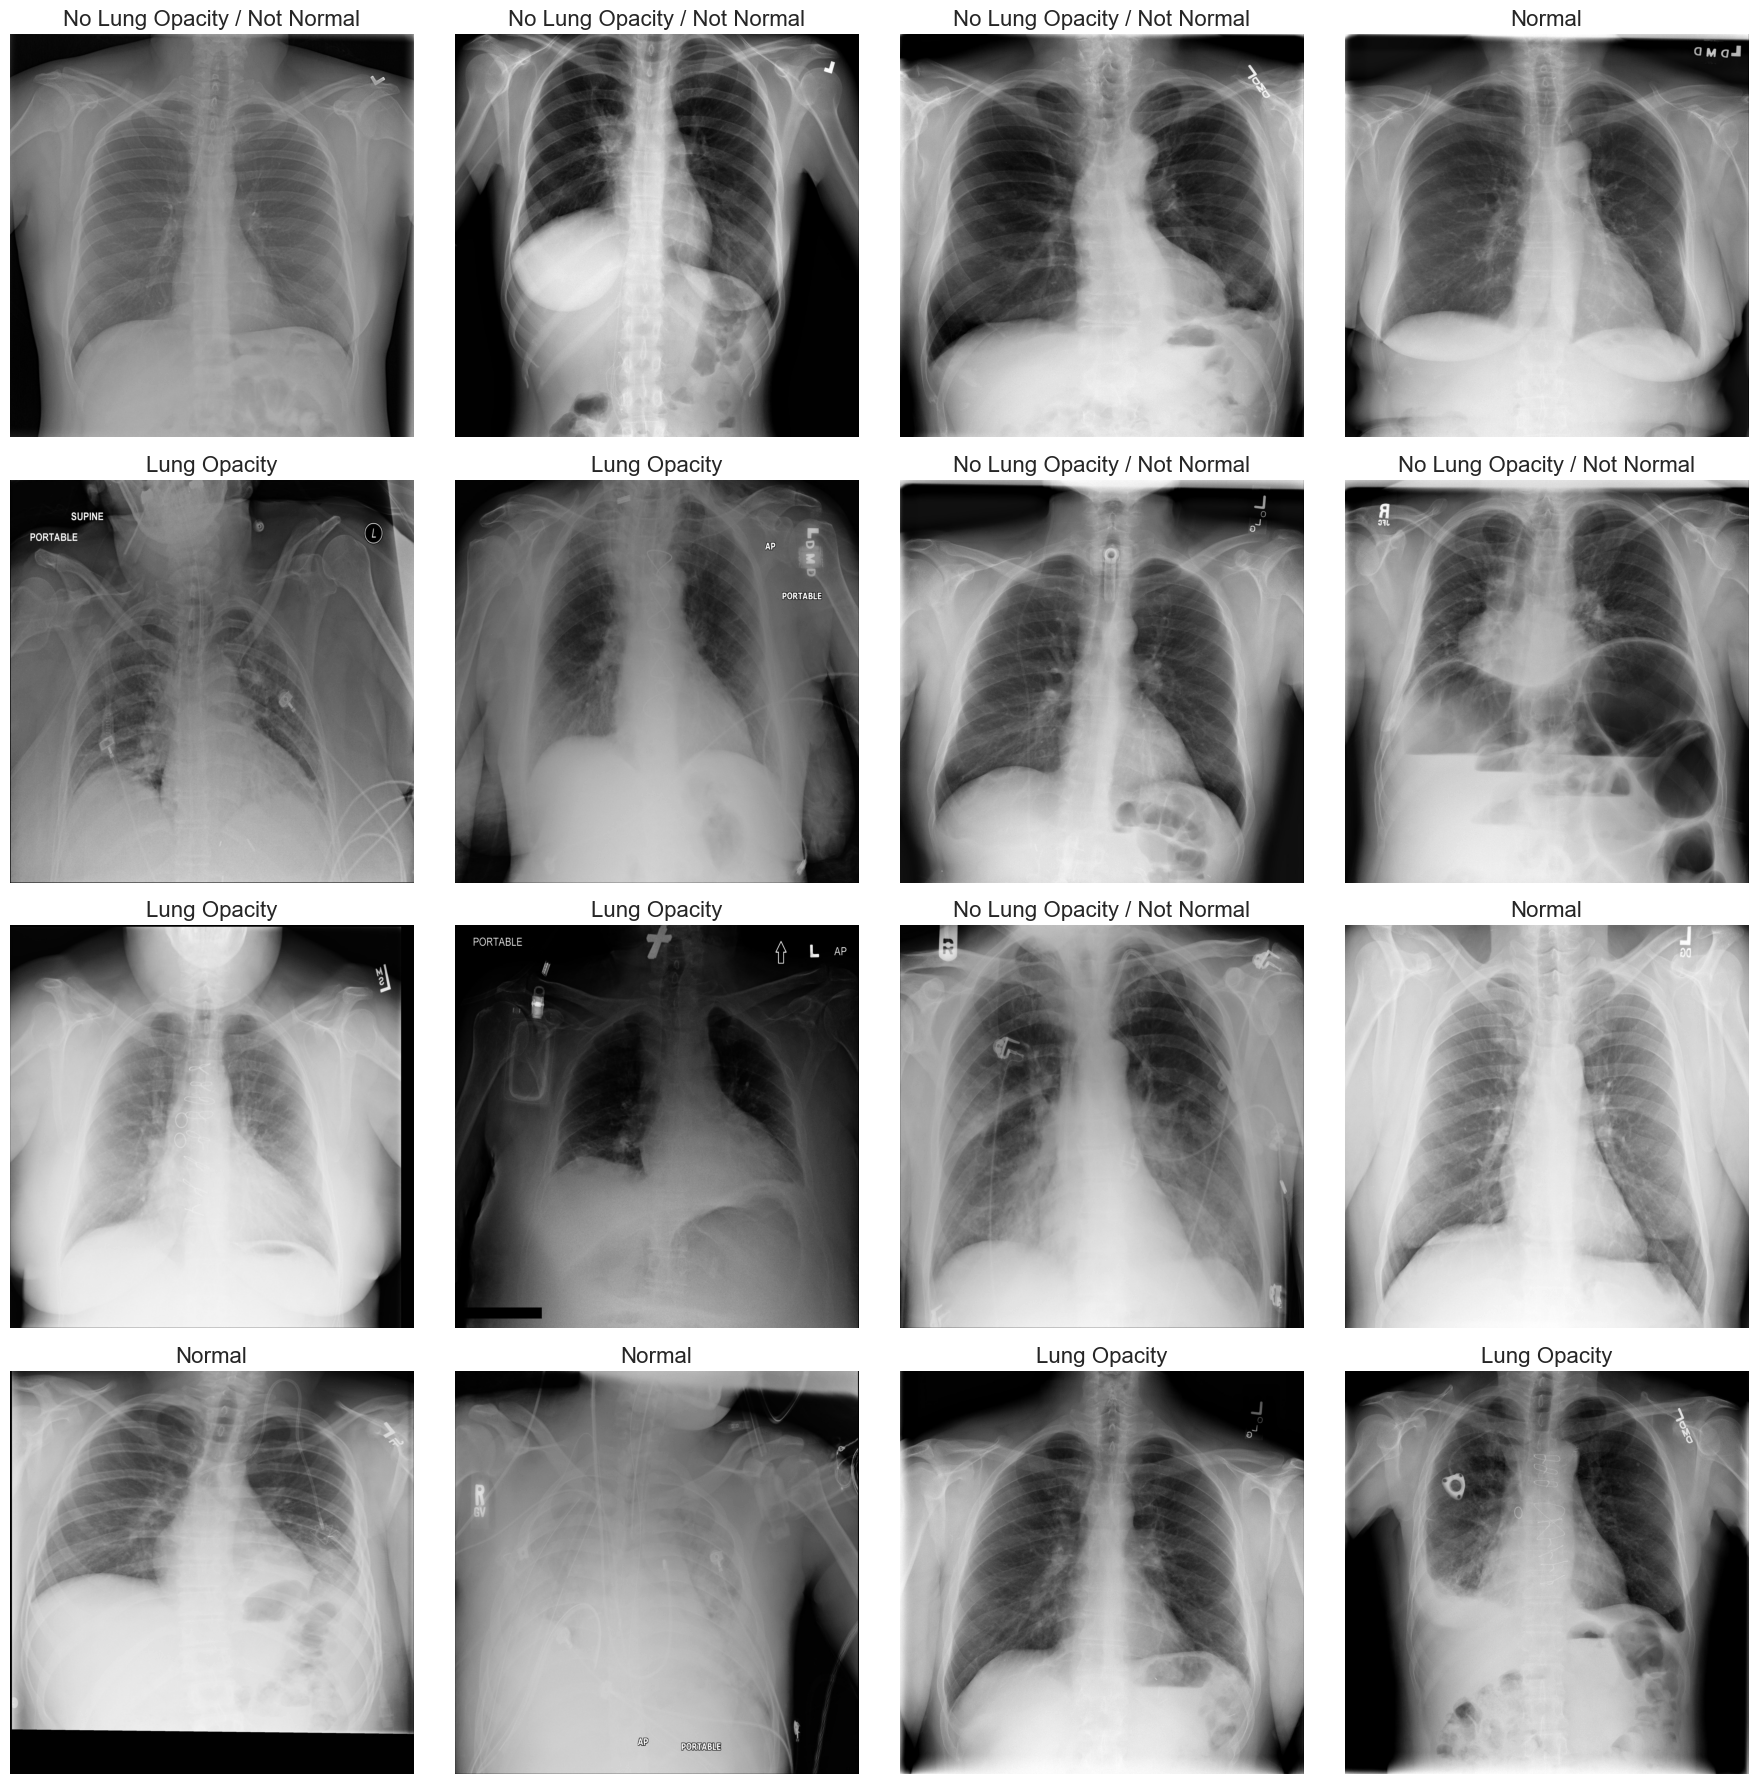

In [33]:
#Test Data Visualization 3O records
visualize_data_class(jpg_test_path, test_df)

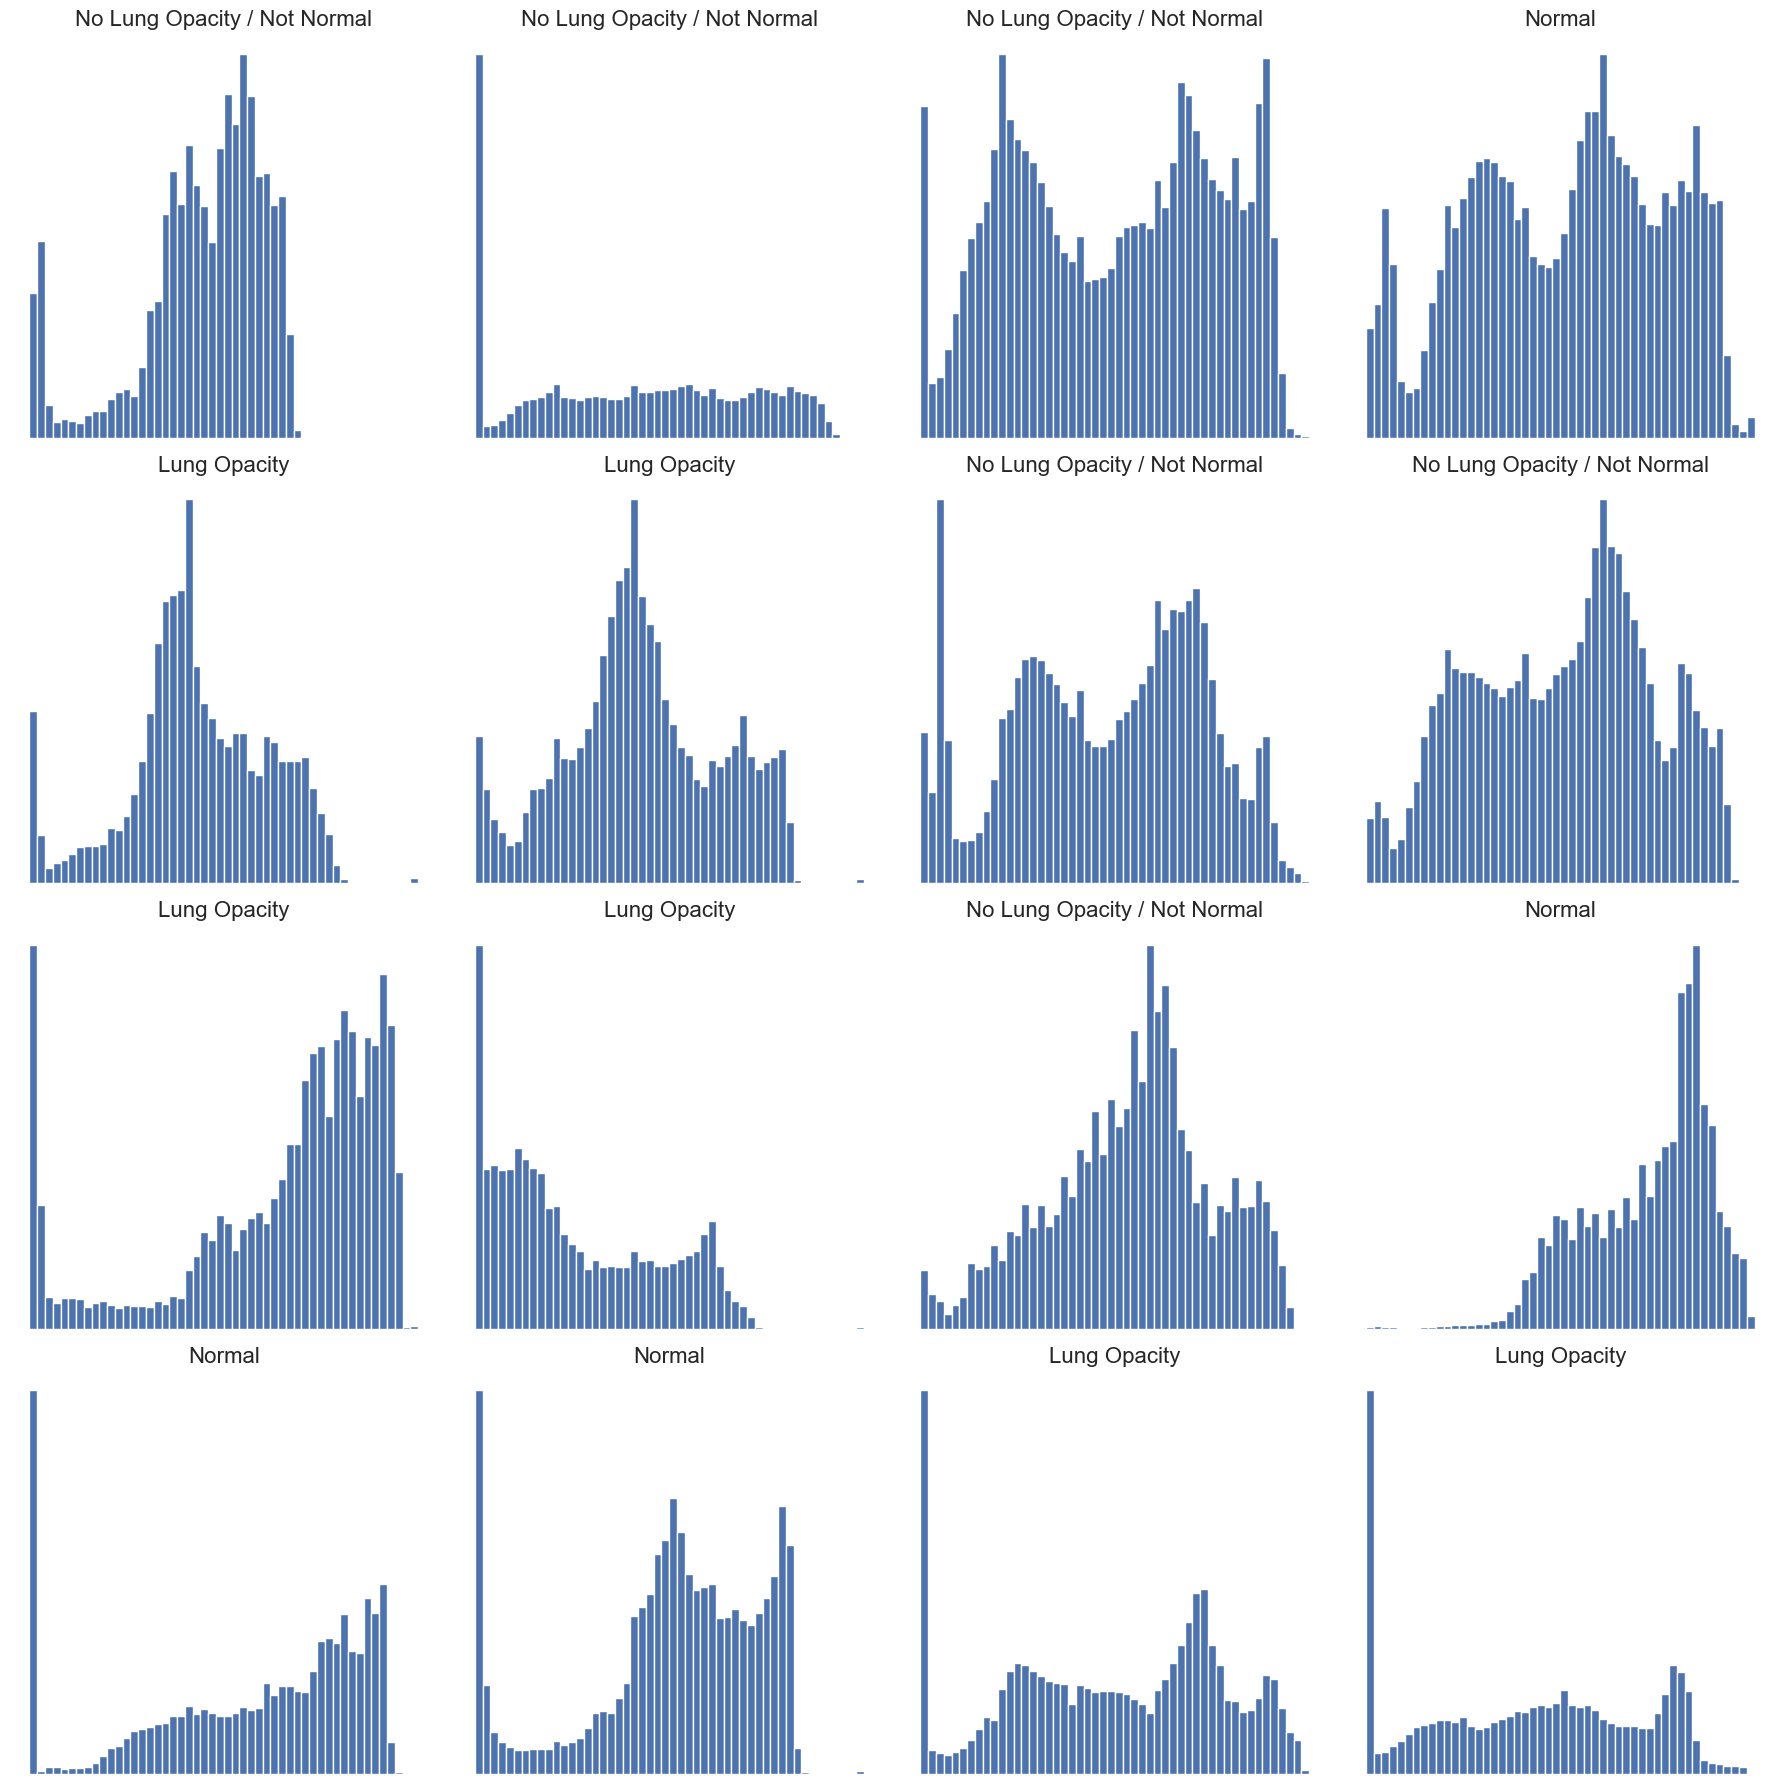

In [34]:
#Image Data visualiztion
histogram_Visualization(jpg_test_path, test_df)

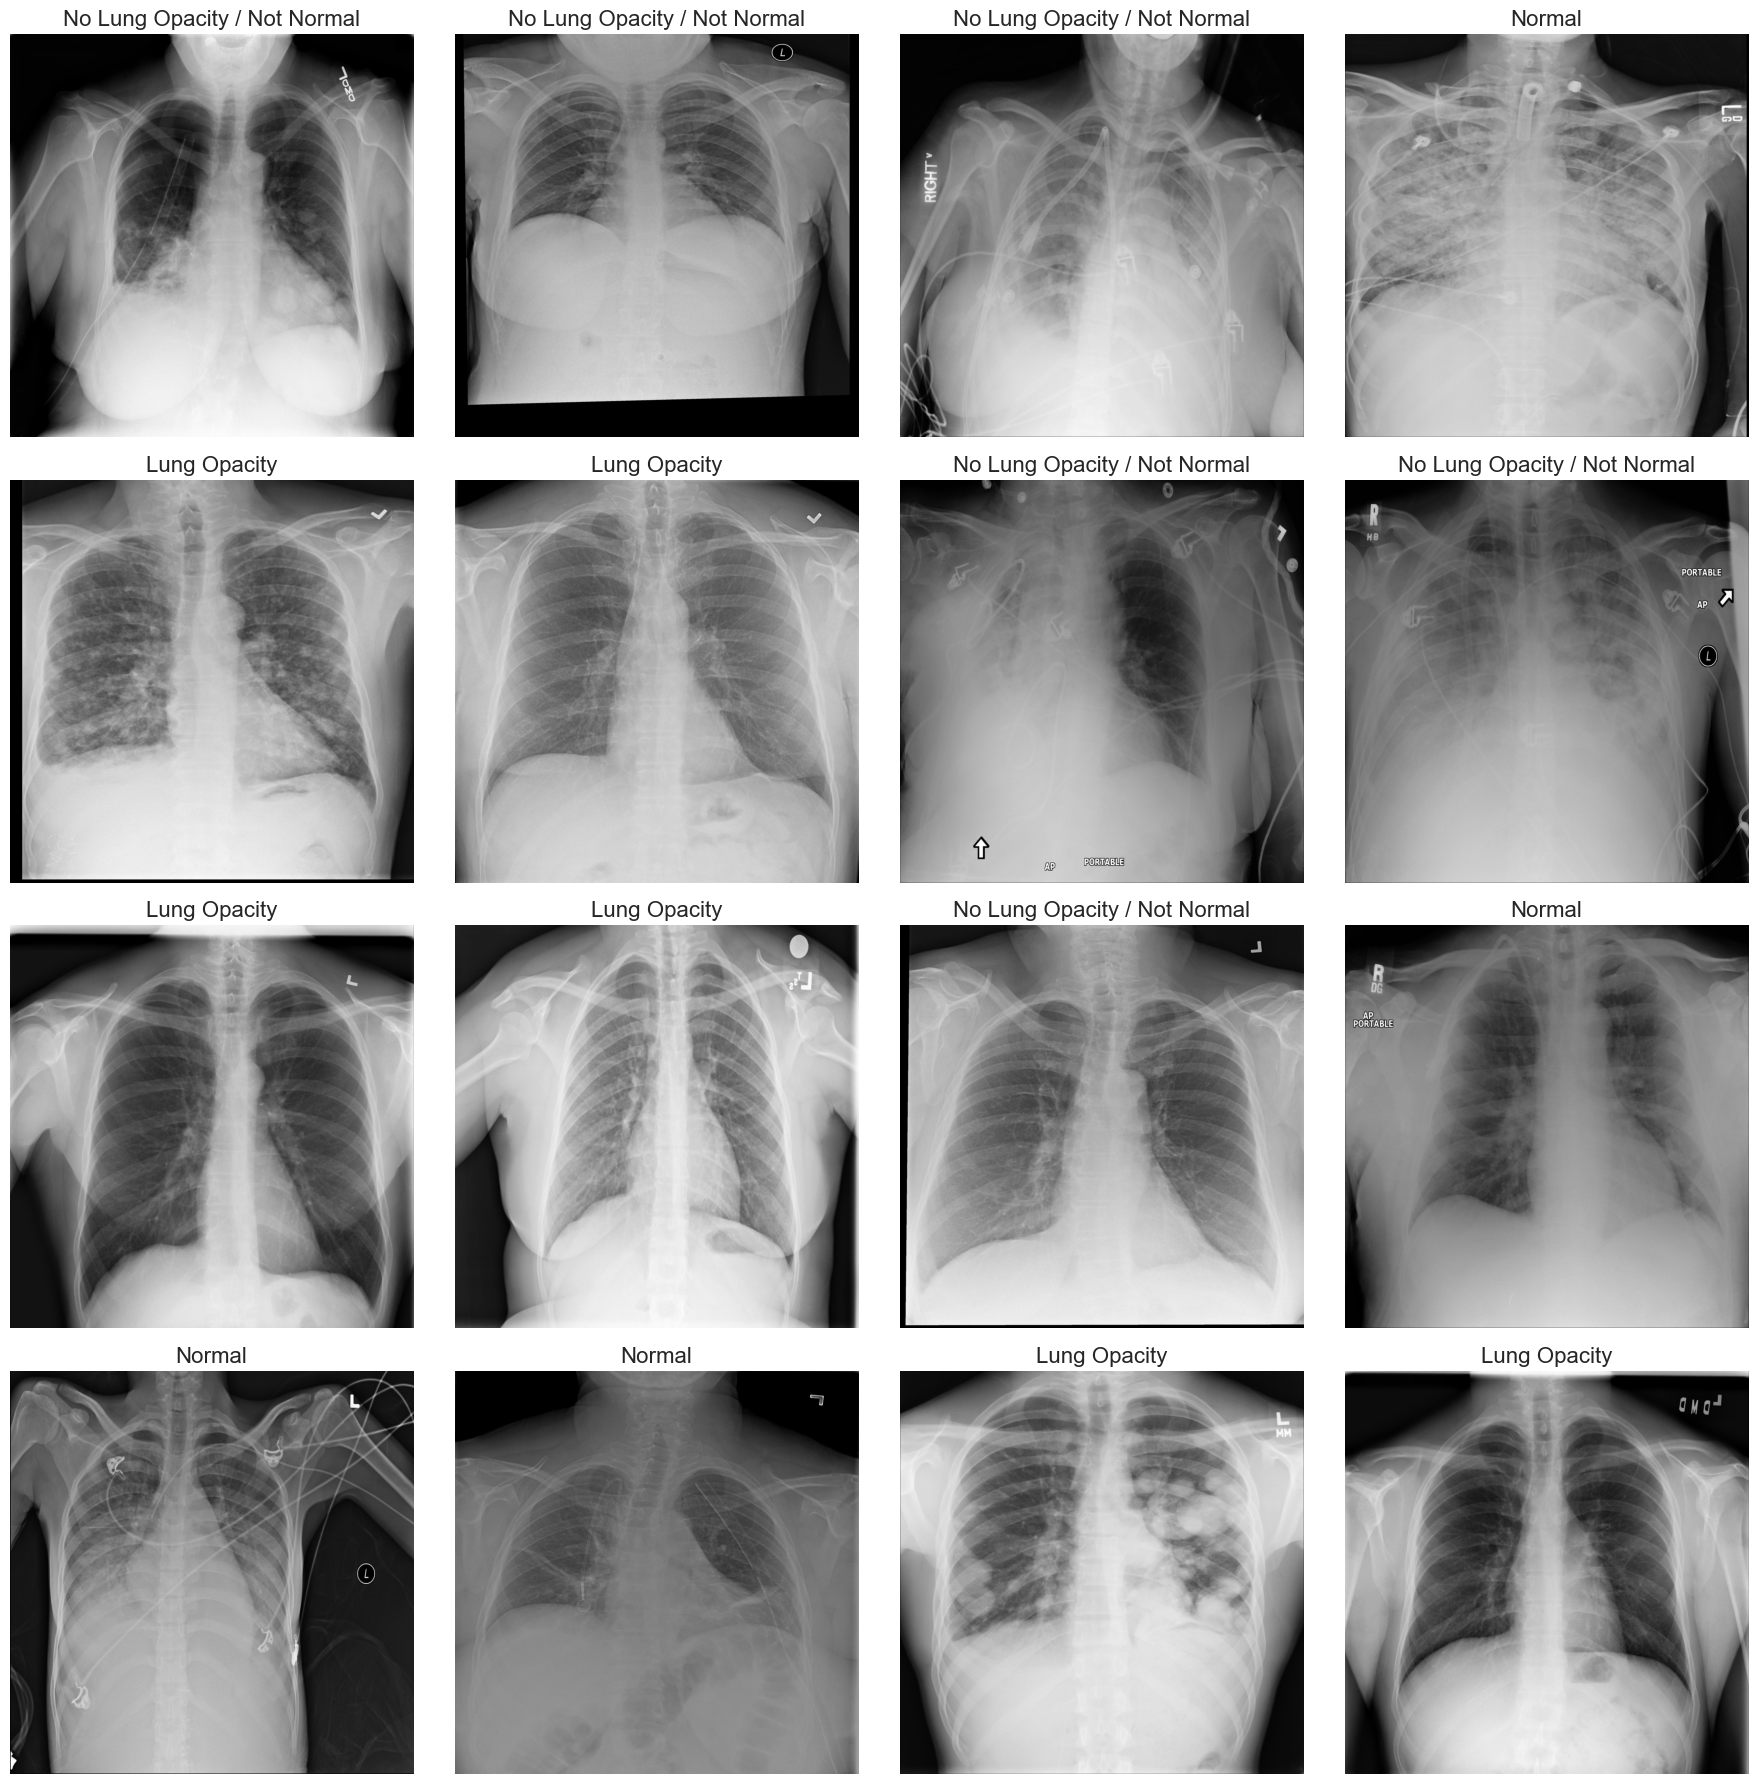

In [35]:
#Traing Data Visualization 30 records
visualize_data_class(jpg_train_path, train_df)

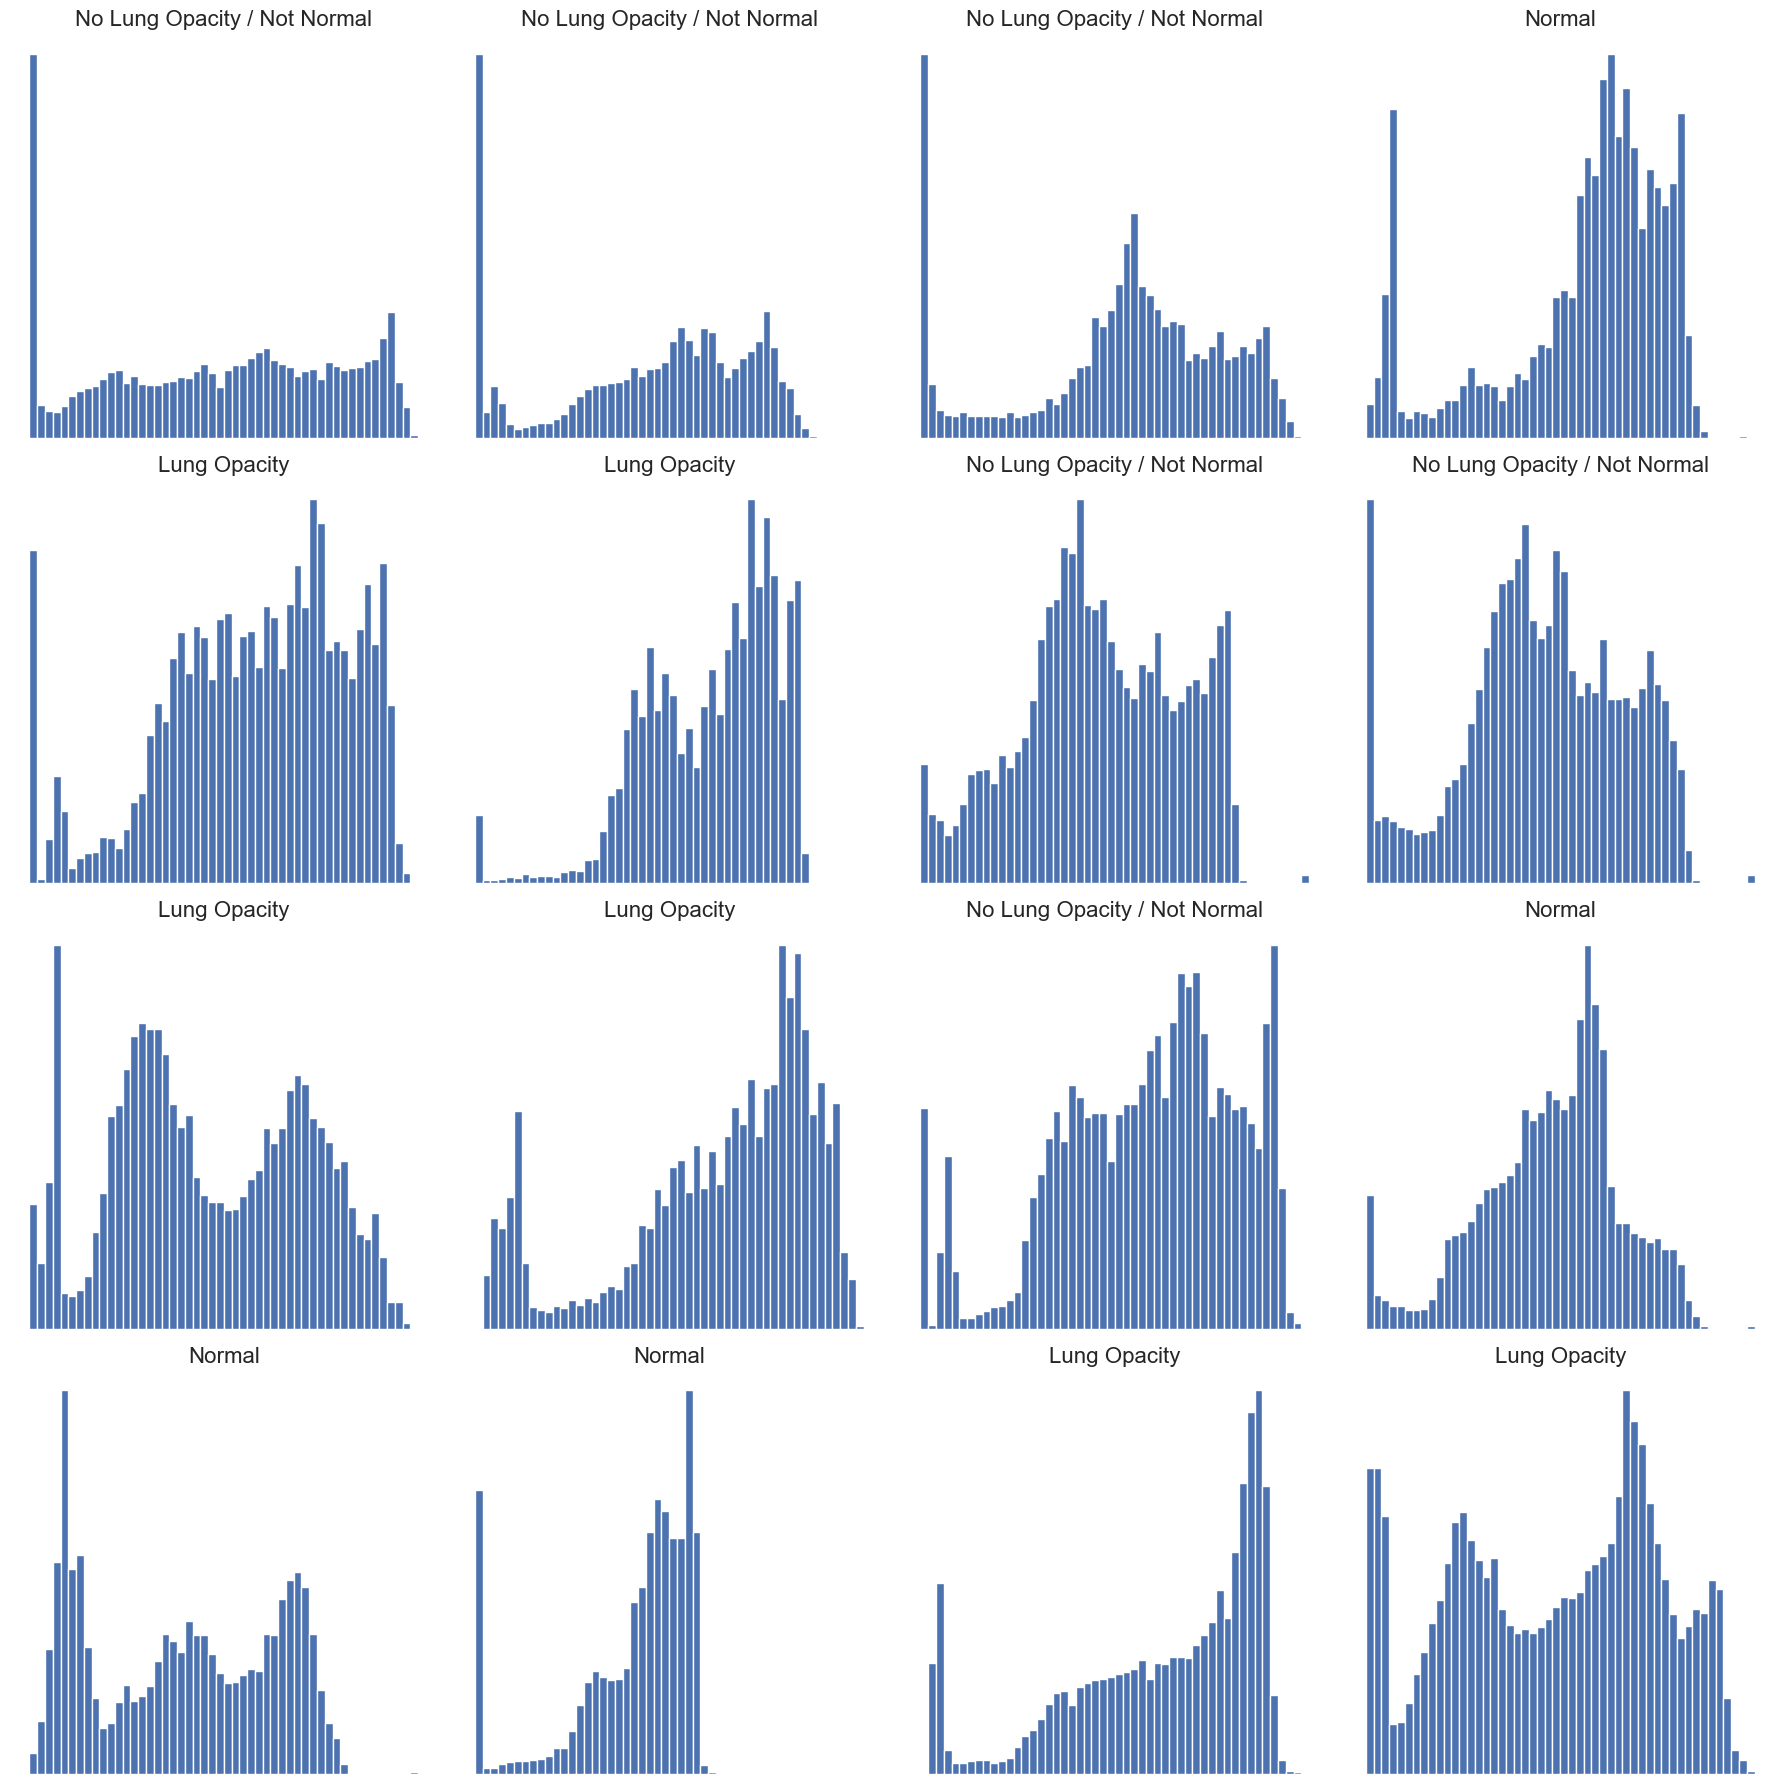

In [36]:
histogram_Visualization(jpg_train_path, train_df)

In [37]:
# Categorical Class Label Encoding 
import category_encoders as ce
#Traingin Data Class Encoding
encoder = ce.OrdinalEncoder(cols=['class'],return_df=True, mapping=[{'col':'class','mapping':{'No Lung Opacity / Not Normal':0,'Normal':1,'Lung Opacity':2}}])
encoder.fit_transform(train_df["class"])
train_df["class_tranform"] = encoder.fit_transform(train_df["class"])
train_df

image                         class  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg  No Lung Opacity / Not Normal   
1      000924cf-0f8d-42bd-9158-1af53881a557.jpg  No Lung Opacity / Not Normal   
2      000db696-cf54-4385-b10b-6b16fbb3f985.jpg  No Lung Opacity / Not Normal   
3      000fe35a-2649-43d4-b027-e67796d412e0.jpg                        Normal   
4      001031d9-f904-4a23-b3e5-2c088acd19c6.jpg                  Lung Opacity   
...                                         ...                           ...   
26679  fffb2395-8edd-4954-8a89-ffe2fd329be3.jpg                        Normal   
26680  fffba05a-1635-4545-9bbd-57ad4cfe8d27.jpg                        Normal   
26681  fffc95b5-605b-4226-80ab-62caec682b22.jpg  No Lung Opacity / Not Normal   
26682  fffcff11-d018-4414-971a-a7cefa327795.jpg  No Lung Opacity / Not Normal   
26683  fffec09e-8a4a-48b1-b33e-ab4890ccd136.jpg  No Lung Opacity / Not Normal   

       class_tranform  
0                   0  
1                   0  
2                   0  
3                   1  
4                   2  
...               ...  
26679               1  
26680               1  
26681               0  
26682               0  
26683               0  

[26684 rows x 3 columns]

In [38]:
#Test Data class enccoding
encoder = ce.OrdinalEncoder(cols=['class'],return_df=True, mapping=[{'col':'class','mapping':{'No Lung Opacity / Not Normal':0,'Normal':1,'Lung Opacity':2}}])
encoder.fit_transform(test_df["class"])
test_df["class_tranform"] = encoder.fit_transform(test_df["class"])
test_df

image                         class  \
0     0000a175-0e68-4ca4-b1af-167204a7e0bc.jpg  No Lung Opacity / Not Normal   
1     0005d3cc-3c3f-40b9-93c3-46231c3eb813.jpg  No Lung Opacity / Not Normal   
2     000686d7-f4fc-448d-97a0-44fa9c5d3aa6.jpg  No Lung Opacity / Not Normal   
3     000e3a7d-c0ca-4349-bb26-5af2d8993c3d.jpg                        Normal   
4     00100a24-854d-423d-a092-edcf6179e061.jpg                  Lung Opacity   
...                                        ...                           ...   
2995  c1e88810-9e4e-4f39-9306-8d314bfc1ff1.jpg                  Lung Opacity   
2996  c1ec035b-377b-416c-a281-f868b7c9b6c3.jpg  No Lung Opacity / Not Normal   
2997  c1ef5b66-0fd7-49d1-ae6b-5af84929414b.jpg  No Lung Opacity / Not Normal   
2998  c1ef6724-f95f-40f1-b25b-de806d9bc39d.jpg                  Lung Opacity   
2999  c1f55e7e-4065-4dc0-993e-a7c1704c6036.jpg                  Lung Opacity   

      class_tranform  
0                  0  
1                  0  
2                  0  
3                  1  
4                  2  
...              ...  
2995               2  
2996               0  
2997               0  
2998               2  
2999               2  

[3000 rows x 3 columns]

In [39]:
from tqdm import tqdm
from time import sleep

img_size = 200
def get_binary_data_process(data_path, data_set):
    data=[]
    row , col = data_set.shape
    for i in tqdm(range(0, row), desc ="Data Process in Progress"):
        try:
            img_arr = cv2.imread(os.path.join(data_path, data_set['image'][i]), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, data_set['class_tranform'][i]])
        except Exception as e:
            print(e)        
        sleep(.01)
    print("Successful")
    return data

In [40]:
#Extrating Binary Images from Test data
test_data_images = get_binary_data_process(jpg_test_path,test_df)

Data Process in Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:41<00:00, 29.69it/s]

Successful


In [41]:
#Extraction Binary Image from training data
train_data_images = get_binary_data_process(jpg_train_path,train_df)

Data Process in Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26684/26684 [15:58<00:00, 27.84it/s]

Successful


0


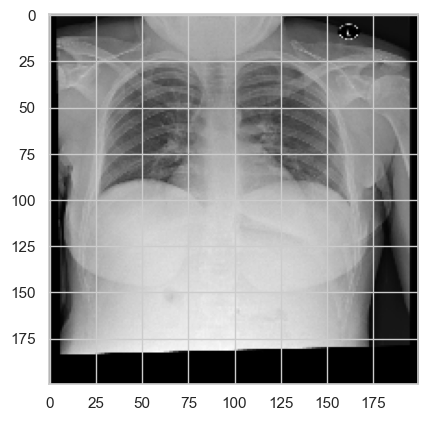

In [42]:
#Binary Normal Data Visualize
plt.imshow(train_data_images[1][0], cmap='gray')
print(train_data_images[1][1])

In [43]:
def show_opacity():
    pid = long_opacity[long_opacity['Target'] == 1]['patientId'].sample(1).iloc[0]
    imgpath = os.path.join(jpg_train_path,pid+".jpg")
    img = cv2.imread(imgpath)
    for index, row in long_opacity[long_opacity['patientId'] == pid].iterrows():
        cv2.rectangle(img,(int(row['x']),int(row['y'])),(int(row['x']) + int(row['width']),int(row['y']) + int(row['height'])),(100,0,0),5)
    
    plt.imshow(img,cmap= 'gray');

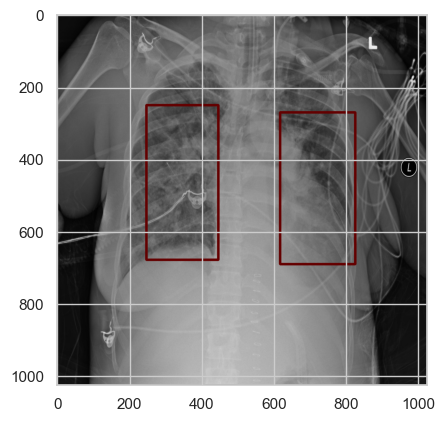

In [44]:
#showing Lung Opacit part
show_opacity()

In [45]:
print(f"After convert Test data=",len(test_data_images))
print(f"After convert Train data=",len(train_data_images))

After convert Test data= 3000
After convert Train data= 26684


In [46]:
import pickle
with open('train_data.pkl', 'wb') as file:
    pickle.dump(train_data_images, file)
    
    
with open('test_data.pkl', 'wb') as file:
    pickle.dump(test_data_images, file)        

In [47]:
#Reading Pikle file
with open(r'train_data.pkl', 'rb') as file:
    imageData = pickle.load(file)

In [48]:
#Train and Test data appending to seperate in to X, y data set  for spliting data  
X = []
y = []
for feature, label in train_data_images:
    X.append(feature)
    y.append(label)
    
#Test data image       
for feature, label in test_data_images:
    X.append(feature)
    y.append(label)

In [49]:
# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

In [50]:
#Suffe Image x and y date
from sklearn.utils import shuffle
X,y = shuffle(X,y,random_state=10)

In [51]:
#Spliting Data Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [52]:
X_train = X_train / 255
X_test = X_test / 255

In [53]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

# print(X_test_val.shape)
# print(y_test_val.shape)

(23747, 200, 200, 1)
(23747,)
(5937, 200, 200, 1)
(5937,)


In [54]:
X_train.shape[1:]

(200, 200, 1)

<h3>Model CNN Desing<h3>

In [55]:
model = Sequential()
model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten()) 
model.add(Dropout(0.5))
model.add(Dense(64))

model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(3))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss')
adam = Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['acc'])

#model.compile(optimizer="adam",loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 256)     2560      
                                                                 
 activation (Activation)     (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 256)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 256)    400       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_1 (Activation)   (None, 100, 100, 64)      0

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.20, callbacks=[early_stop])
#history = model.fit(X_train, y_train, batch_size=15, epochs=6, validation_data=(X_test_val,y_test_val), callbacks=[early_stop])

In [ ]:
model.evaluate(X_test, y_test)

<h4>Traing Evaluation </h4>

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(10, ))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

In [ ]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    

In [ ]:
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [ ]:
predictions = model.predict(X_test)

<h5>Scalling and Normalizing Images</h5>

In [57]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# one hot encode target values
trainY = to_categorical(y_train)
testY = to_categorical(y_test)
# confirm scale of pixels
print('Train min=%.3f, max=%.3f' % (X_train.min(), X_train.max()))
print('Test min=%.3f, max=%.3f' % (X_test.min(), X_test.max()))

Train min=0.000, max=1.000
Test min=0.000, max=1.000


In [61]:
#Normalization Image
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_itr = datagen.flow(X_train, trainY, batch_size=64)
test_itr = datagen.flow(X_test, testY, batch_size=64)
print('Batches train=%d, test=%d' % (len(train_itr), len(test_itr)))

Batches train=372, test=93


In [ ]:
#confirm the scaling works
batchX, batchy = train_itr.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(64, 200, 200, 1), min=0.000, max=0.004


In [60]:
# define model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

early_stop = EarlyStopping(patience=3, monitor='val_loss')
adam = Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['acc'])

In [288]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 147456)            0         
                                                                 
 dense_12 (Dense)            (None, 64)               

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.20, callbacks=[early_stop])

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0, samplewise_center=True, samplewise_std_normalization=True)
# calculate mean on training dataset
datagen.fit(X_train)
# prepare an iterators to scale images
trainX_scal = datagen.flow(X_train,y_train, batch_size=64)
testX_scal = datagen.flow(X_test, y_test, batch_size=64)
print('Batches train=%d, test=%d' % (len(trainX_scal),len(testX_scal)))

In [ ]:
# confirm the scaling works
batchX, batchy = trainX_scal.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))